# Measure and parameterize dropoff in $f_{features}$ for FERENGI-fied images in Galaxy Zoo: Hubble

In [10]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table
from scipy import optimize
from scipy.stats import distributions as dist
import numpy as np

In [11]:
# Load data

data = Table.read("../data/ferengi_debiasable_data.fits")

# Use only galaxies with surface brightness/redshift ranges that are considered "debiasable"

data = data[data['Debiasable']]

# Limit to galaxies that have data at z_sim = 0.3, since that's what we're normalizing to.
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < 0.501:
        z0ind[ind] = True
        
data_z0 = data[z0ind]

##### "Zeta method"

Assume that the change in $f_{features}$ as a function of redshift can be parameterized as:

$\frac{f_f}{f_{f,z=z_0}} = e^{-\frac{(z-z_0)}{\zeta}}$

where we set $z_0=0.3$, the lowest redshift in the FERENGIed images.

In [12]:
def fzeta_exp(p,x):
    
    #y = p[0] * np.exp(-1 * (x-p[1])/p[2])
    
    y = np.exp(-1 * (x-0.3)/p[0])

    return y
    
def fzeta_lin(p,x):
    
    y = p[0] + p[1] * x

    return y

def fzeta(p,x):
    # results are qualitatively the same for both lin and exp versions
    return fzeta_exp(p,x)

def errfunc(p,x,y,s):
    
    err = (y - fzeta(p,x))/s

    return err

def errfunc_lin(p,x,y,s):
    
    err = (y - fzeta_lin(p,x))/s

    return err

def error_bars(k,n=40,c=0.683):

    f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
    
    return f_gal_err

def common_labels(fig,xlabel=None,ylabel=None,xfontsize=12,yfontsize=12):

    # Set common labels
    cax = fig.add_subplot(111)    # The big subplot
    cax.set_axis_bgcolor('none')
    cax.spines['top'].set_color('none')
    cax.spines['bottom'].set_color('none')
    cax.spines['left'].set_color('none')
    cax.spines['right'].set_color('none')
    cax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    cax.set_xlabel(xlabel,fontsize=xfontsize)
    cax.set_ylabel(ylabel,fontsize=yfontsize)

    return cax

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


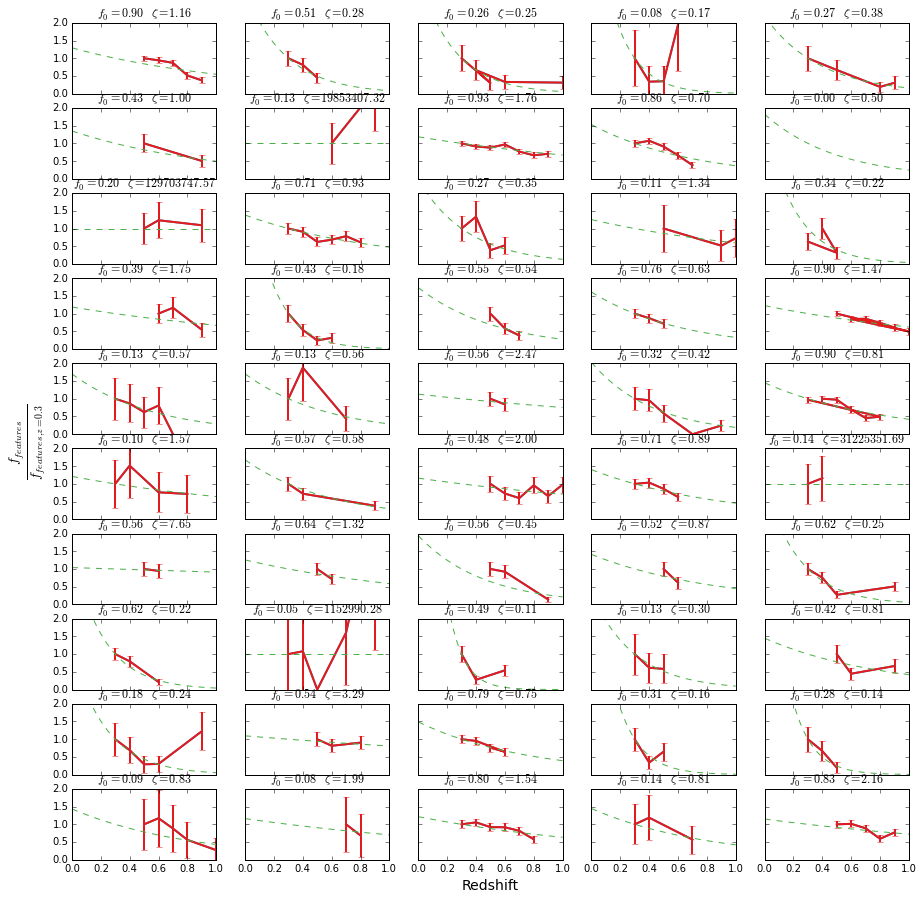

In [13]:
p_guess = np.array([0.5])

# Set up plot
fig,axarr = plt.subplots(nrows=10,ncols=5,sharex=True,sharey=True,figsize=(15,15))
bigax = common_labels(fig,'Redshift',r'$\frac{f_{features}}{f_{features,z=0.3}}$',14,20)
zarr = np.linspace(0,1,50)

# For examples, only plot galaxies with an evolution correction of zero.
evol = 0.0
e0 = data_z0[np.absolute(data_z0['sim_evolution'] - evol) < 0.001]
unique_galaxies = set(e0['sdss_id'])

for ax in axarr.ravel():
    
    slen = 0
    # Make sure there are enough points to fit a function
    while slen < (len(p_guess)+1):
        ind = (e0['sdss_id'] == unique_galaxies.pop())
        slen = sum(ind)
        
    galaxy1 = e0[ind]

    z_gal = galaxy1['sim_redshift']
    f_gal = galaxy1['p_features']
    
    #  ADD ERROR BARS
    n = 40  # assume 40 classifications per galaxy; it'd be better to use true value, though
    f_gal_err = error_bars(f_gal*n,n)
    f_gal_norm = f_gal / f_gal[0]
    f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm

    # Values must be explicitly cast as double-type precision for optimization to work. Incredibly frustrating.
    # Fix: http://stackoverflow.com/questions/12473406/scipy-optimize-leastsq-returns-best-guess-parameters-not-new-best-fit 

    p, cov, infodict, mesg, ier = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),
                                                                         f_gal_norm.astype(np.float64),
                                                                         f_gal_norm_err.astype(np.float64)),
                                                   full_output=1)
    ax.plot(z_gal,f_gal_norm,lw=2)
    ax.errorbar(z_gal,f_gal_norm, f_gal_norm_err)
    ax.plot(zarr,fzeta_exp(p,zarr),'--',lw=1)
    ax.set_title('$f_0={:.2f}\; \zeta={:.2f}$'.format(f_gal[0], p[0]))
    ax.set_xlim(0,1)
    ax.set_ylim(0,2)

In [14]:
# Find zeta for all images

data_z0['zeta'] = np.ones(len(data_z0)) * -99
data_z0['delchisq'] = np.ones(len(data_z0)) * -99

for gal in unique_galaxies:
    
    # Loop over evolution corrections
    
    for evo in set(data_z0['sim_evolution']):
        
        # Find data for this galaxy at all redshifts
        
        ind = (data_z0['sdss_id'] == gal) & (np.absolute(data_z0['sim_evolution'] - evo) < 0.001)
        
        # Make sure there are enough points to fit a function
        if sum(ind) > 3:
        
            galaxy1 = data_z0[ind]
            
            z_gal = galaxy1['sim_redshift']
            f_gal = galaxy1['p_features']
            
            #  ADD SOME ROUGH ERROR BARS
            f_gal_err = error_bars(f_gal*n,n)
            f_gal_norm = f_gal / f_gal[0]
            f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm
            
            try:
                p, cov = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),f_gal_norm.astype(np.float64),
                                                                f_gal_norm_err.astype(np.float64)))
                zeta = p[0]
                chisq = (((f_gal_norm - fzeta(p,z_gal)) / f_gal_norm_err)**2).sum()
                chisq_const = (((f_gal_norm - f_gal_norm.mean()) / f_gal_norm_err)**2).sum()
                delchisq = chisq_const - chisq
            except TypeError:
                print 'Galaxy %s has only %i redshifted images' % (galaxy1['sdss_id'][0],len(z_gal))
                zeta = -99.
                
            # Add zeta values to the larger table
            data_z0['zeta'][ind] = p[0]
            data_z0['delchisq'][ind] = delchisq

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:27: RuntimeWarning: divide by zero encountered in double_scalars


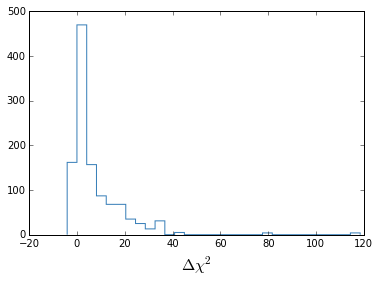

In [15]:
# Plot the distribution of delta chi^2
_ = plt.hist(data_z0['delchisq'][data_z0['delchisq']>-5], 30, histtype='step')
plt.xlabel(r"$\Delta \chi^2$",fontsize=16)

In [16]:
# How many galaxies have well-measured zeta values?

print '%i galaxies have well-measured zeta values' % ((data_z0['zeta'] < 10.) & (data_z0['zeta'] > -99.)).sum()
print '%i galaxies have zeta = -99' % (data_z0['zeta'] == -99.).sum()
print len(data_z0['zeta'])

1052 galaxies have well-measured zeta values
1982 galaxies have zeta = -99
3119


95 (34 unique) galaxies with measured zeta values.



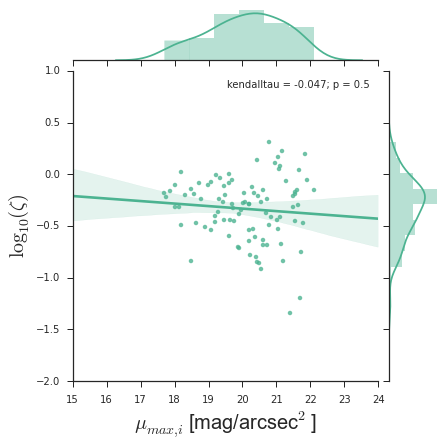

In [17]:
# Plot distribution of zeta as function of surface brightness
from scipy.stats import kendalltau
import seaborn as sns

sns.set(style="ticks")

# Only select unique galaxies (zeta is the same for all evolution corrections)

dz3 = data_z0[(data_z0['sim_redshift'] == 0.3) & (data_z0['p_features'] >= 0.0) & (data_z0['delchisq'] > 3.0)]

# Limit zeta to "sensible" values
zetalim = dz3[(dz3['zeta'] < 10.) & (dz3['zeta'] > -98.)]
x = zetalim['mu_max_i']
y = np.log10(zetalim['zeta'])
print "%i (%i unique) galaxies with measured zeta values.\n" % (len(zetalim),len(set(zetalim['sdss_id'])))

jg = sns.jointplot(x, y, kind="reg", stat_func=kendalltau, color="#4CB391")
jg.set_axis_labels(r'$\mu_{max,i}$ [mag/arcsec$^2$]',r'$\log_{10}(\zeta)$',fontsize=20)

In [18]:
fit = jg.ax_joint.lines[0].get_data()
x0,y0 = fit[0][0],fit[1][0]
x1,y1 = fit[0][-1],fit[1][-1]

# Slope, intercept where x = SB, y = log_10(zeta)
slope = (y1-y0)/(x1-x0)
intercept = y1 - slope*x1

$\log_{10}\zeta = m\mu + b$

$\zeta = 10^{m\mu + b}$

In [19]:
print('zeta = {:.1f} is a reasonable first order correction'.format(10**y.mean()))
print('For a slightly improved correction, fit with the linear function such that log_10(zeta) = ({:.1f} * SB) + {:.1f}'.format(slope,intercept))

zeta = 0.5 is a reasonable first order correction
For a slightly improved correction, fit with the linear function such that log_10(zeta) = (-0.0 * SB) + 0.2


### OK. We have a fit for $\zeta$ based on the SB-$z$ space that should be correctable. Now to actually *correct* all the Hubble data based on this trend!

In [20]:
#hstdata = Table.read("/Users/willettk/Astronomy/Research/GalaxyZoo/fits/gz_hst_acs_all.fits",1)

# Mel's HST data where she has identified galaxies that can be corrected

hstdata = Table.read('/Users/willettk/Astronomy/Research/GalaxyZoo/gzhubble/')

$\hat\zeta = \zeta_0 + \zeta_1 \times SB$

$\hat f = f \times e^{z/{\hat\zeta}}$

In [31]:
# Use SB-dependent value, even though the scatter is huge.
p_guess = np.array([0.5,0.5])
n = 40
yerr = error_bars(y*n,n)
f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm

p, cov = optimize.leastsq(errfunc_lin,p_guess,args=(x.astype(np.float64),y.astype(np.float64),yerr.astype(np.float64)))

zeta_mean = 10**y.mean()
z0 = 0.3

print(hstdata['Z'].max(),hstdata['Z'].min())

(9.9998999, -999.0)


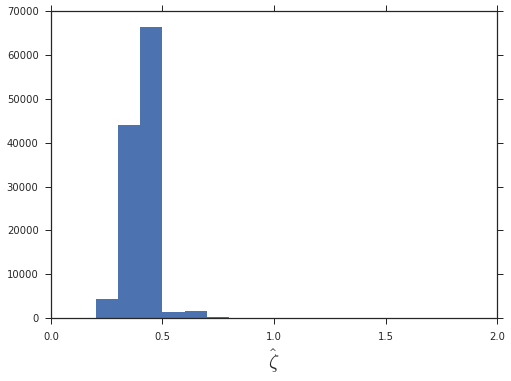

In [32]:
mu = hstdata['MU_HI']
zeta_hat = 10**(slope * mu + intercept)
plt.hist(zeta_hat[np.isfinite(zeta_hat)],bins=20,range=(0,2))
plt.xlabel(r'$\hat\zeta$',fontsize=20)

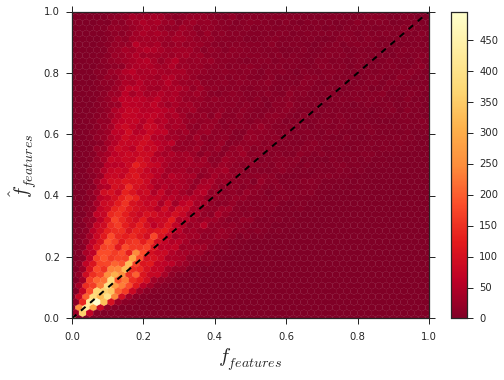

In [35]:
old = hstdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
new = old * np.exp((hstdata['Z'] - z0)/ zeta_hat)
good_z = (hstdata['Z'] > 0.) & (hstdata['Z'] < 9.) & (new <= 1.)

'''
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#ax.scatter(old[good_z],new[good_z])
ax.set_xlabel(r'$f_{features}$',fontsize=20)
ax.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax.set_ylim(0,1)
'''

# 2D histogram of new p_features distribution
plt.hexbin(old[good_z],new[good_z], cmap=plt.cm.YlOrRd_r,gridsize=50)
plt.xlabel(r'$f_{features}$',fontsize=20)
plt.ylabel(r'$\hat f_{features}$',fontsize=20)
cb = plt.colorbar()

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

plt.plot([0,1],[0,1],color='k',lw=2,ls='--')